In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
import math

In [2]:
import gc
torch.cuda.empty_cache()
gc.collect()


34

## Setup

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

IMG_SIZE = 32
BATCH_SIZE = 32
EPOCHS = 100
NUM_SAMPLES = 1000

cuda


## Load data

In [6]:
transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3),
])

train_data = ImageFolder('train/', transform=transform)
loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)

## Diffusion model

In [15]:
# Sinusoidal Time Embedding
def get_timestep_embedding(timesteps, dim):
    half_dim = dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

def get_valid_num_groups(channels, max_groups=8):
    for g in reversed(range(1, max_groups + 1)):
        if channels % g == 0:
            return g
    return 1  # fallback to LayerNorm-like behavior


class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        g1 = get_valid_num_groups(in_ch)
        g2 = get_valid_num_groups(out_ch)

        self.norm1 = nn.GroupNorm(g1, in_ch)
        self.act1 = nn.SiLU()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)

        self.norm2 = nn.GroupNorm(g2, out_ch)
        self.act2 = nn.SiLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

        self.time_proj = nn.Linear(time_emb_dim, out_ch)
        self.residual_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(self.act1(self.norm1(x)))
        h = h + self.time_proj(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = self.conv2(self.act2(self.norm2(h)))
        return h + self.residual_conv(x)

# Upgraded UNet
class UpgradedUNet(nn.Module):
    def __init__(self, time_emb_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

        self.down1 = ResBlock(3, 64, time_emb_dim)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = ResBlock(64, 128, time_emb_dim)
        self.pool2 = nn.MaxPool2d(2)

        self.middle = ResBlock(128, 256, time_emb_dim)

        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up_block1 = ResBlock(256, 128, time_emb_dim)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up_block2 = ResBlock(128, 64, time_emb_dim)

        self.out_conv = nn.Conv2d(64, 3, 1)

    def forward(self, x, t):
        t_emb = get_timestep_embedding(t, 128)
        t_emb = self.time_mlp(t_emb)

        d1 = self.down1(x, t_emb)
        d2 = self.down2(self.pool1(d1), t_emb)
        m = self.middle(self.pool2(d2), t_emb)

        u1 = self.up1(m)
        u1 = self.up_block1(torch.cat([u1, d2], dim=1), t_emb)

        u2 = self.up2(u1)
        u2 = self.up_block2(torch.cat([u2, d1], dim=1), t_emb)

        return self.out_conv(u2)


@torch.no_grad()
def denorm(x):
    return x * 0.5 + 0.5

@torch.no_grad()
def show_images(images, num=16):
    images = denorm(images[:num].cpu()).permute(0, 2, 3, 1).numpy()
    fig, axes = plt.subplots(int(num ** 0.5), int(num ** 0.5), figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.clip(images[i], 0, 1))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def get_beta_schedule(T, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, T)

class DDPM:
    def __init__(self, model, T=250):
        self.model = model.to(device)
        self.T = T
        self.betas = get_beta_schedule(T).to(device)
        self.alphas = 1. - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)

    def noise_images(self, x0, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        noise = torch.randn_like(x0)
        return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise, noise

    def train_step(self, x0):
        t = torch.randint(0, self.T, (x0.shape[0],), device=device).long()
        xt, noise = self.noise_images(x0, t)
        pred = self.model(xt, t.float() / self.T)
        return F.mse_loss(pred, noise)
    
    @torch.no_grad()
    def sample(self, n):
        x = torch.randn(n, 3, IMG_SIZE, IMG_SIZE).to(device)
        for t in tqdm(reversed(range(self.T))):
            z = torch.randn_like(x) if t > 0 else 0
            alpha = self.alphas[t]
            alpha_hat = self.alpha_hat[t]
            beta = self.betas[t]

            pred_noise = self.model(x, torch.tensor([t / self.T]).to(device).repeat(n))

            x = (1 / torch.sqrt(alpha)) * (x - (1 - alpha) / torch.sqrt(1 - alpha_hat) * pred_noise) + torch.sqrt(beta) * z
        torch.cuda.empty_cache()
        return x

### Train the model

In [16]:
model = UpgradedUNet()
ddpm = DDPM(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

losses = []
for epoch in range(EPOCHS):
    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=True)
    
    for batch in progress_bar:
        x, _ = batch
        x = x.to(device)
        loss = ddpm.train_step(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")
    scheduler.step()

Epoch 1/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 55/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 56/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 57/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 58/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 59/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 60/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 61/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 62/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 63/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 64/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 65/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 66/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 67/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 68/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 69/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 70/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 71/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 72/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 73/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 74/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 75/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 76/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 77/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 78/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 79/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 80/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 81/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 82/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 83/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 84/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 85/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 86/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 87/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 88/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 89/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 90/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 91/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 92/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 93/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 94/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 95/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 96/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 97/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 98/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 99/100:   0%|          | 0/1225 [00:00<?, ?it/s]

Epoch 100/100:   0%|          | 0/1225 [00:00<?, ?it/s]

1225


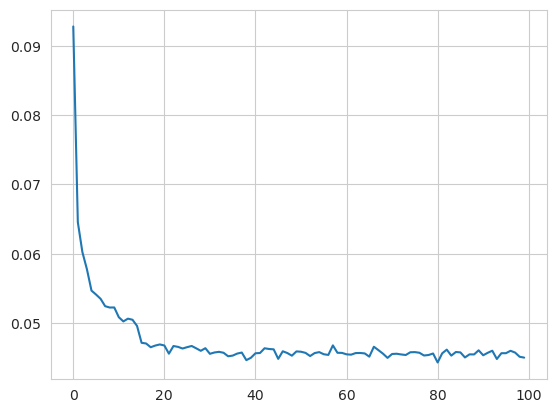

In [18]:
# average
print(len(loader.dataset)//BATCH_SIZE)
averages_losses = []
step = 1224
for i in range(len(losses) // step):
    averages_losses.append(sum(losses[i*step:(i+1)*step])/step)
    

plt.plot(range(len(averages_losses)), averages_losses)
plt.show()

0it [00:00, ?it/s]

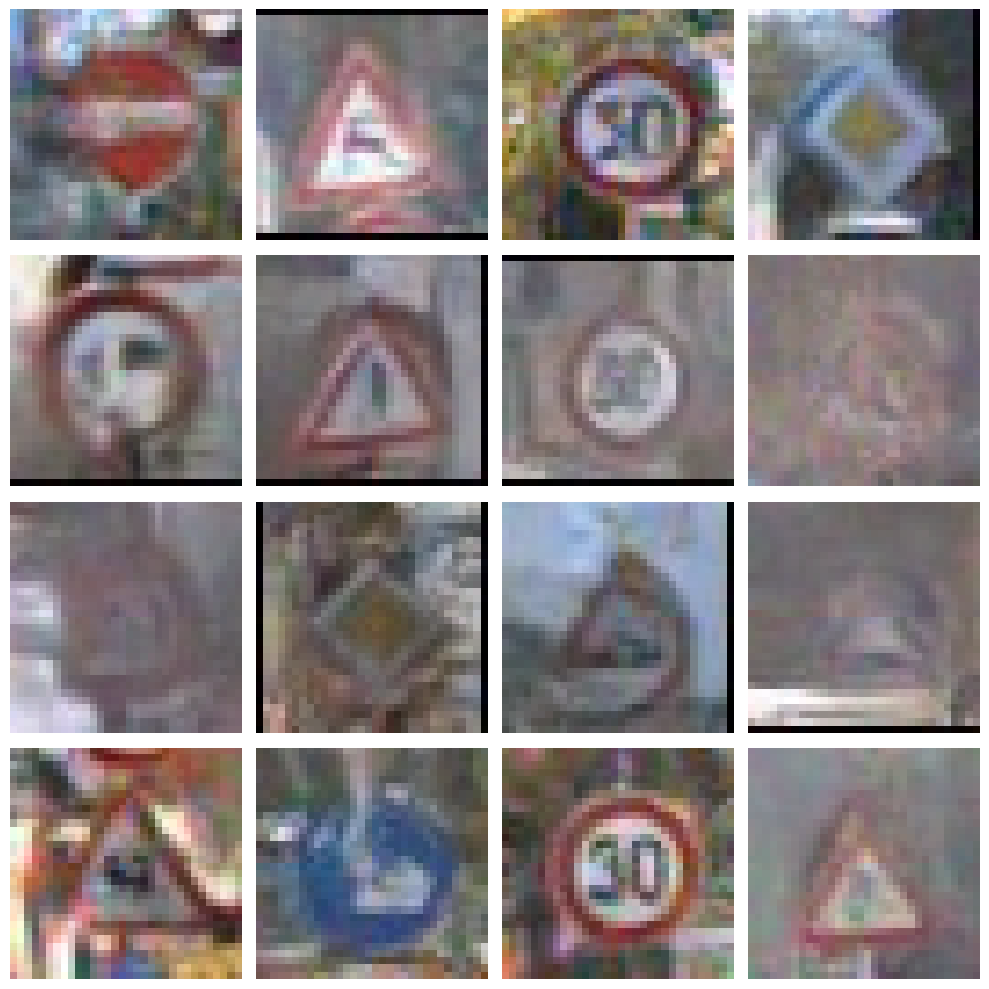

In [21]:
model.eval()
samples = ddpm.sample(1000)
show_images(samples, num=16)

In [23]:
for i in range(samples.size(0)):
    img = denorm(samples[i])
    save_image(img, f"model3/images/image_{i:04d}.png")

In [24]:
state_dict = model.state_dict()
torch.save(state_dict, "traffic_generative_diffusion_v3.tar")

# Evaluation

In [25]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out  = nn.Linear(50, 43)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x
    

    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x

evaluator = Evaluator(3*32*32, 256).to(device)

In [26]:
# Optimizers
optimizer = torch.optim.Adam(evaluator.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.97)

# loss
criterion = nn.CrossEntropyLoss()

In [27]:
num_epochs = 10
for epoch in range(num_epochs):
    for data, targets in iter(loader):
        data = data.to(device)
        targets = targets.to(device)

        results = evaluator(data)
        loss = criterion(results, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss.item())

0.9224392771720886
1.0828784704208374
0.3075757622718811
1.3805972337722778
0.48788511753082275
0.21699951589107513
0.1607206016778946
0.3006042242050171
0.3433392643928528
0.2515786290168762


In [55]:
orig_data = [x[0] for x in list(train_data)[:1000]]
orig_data = torch.cat(orig_data).view(1000, 3, 32, 32)

In [71]:
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_diff = evaluator.get_features(samples.to(device)).cpu()

In [57]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [72]:
for name, obj in zip(['orig','diff','gan','cond_gan'],[dist_orig_data.numpy(),dist_diff.numpy()]):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(),obj)}")

FD orig: 2.8194335754960775e-11
FD diff: 3899.357834478981
